https://www.kaggle.com/c/titanic
https://www.kaggle.com/alexisbcook/titanic-tutorial   
https://app.dataquest.io/m/289/introduction-to-numpy/7/selecting-columns-and-custom-slicing-ndarrays
https://neurohive.io/ru/osnovy-data-science/razbor-resheniya-zadachi-titanik-na-kaggle-dlya-nachinajushhih/
https://habr.com/ru/post/274171/
https://habr.com/ru/post/202090/
https://habr.com/ru/post/470535/ 
https://www.kaggle.com/fireballbyedimyrnmom/eda-marketing-data?select=marketing_data.csv

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot,show,hist
from scipy.stats.kde import gaussian_kde
from numpy import linspace,hstack
from pylab import plot,show,hist
#%config InlineBackend.figure_format = 'svg' для большей четкости графиков
matplotlib.style.use('ggplot')
%matplotlib inline


os.chdir(r'C:\Users\Mr Alex\Documents\GitHub\Kaggle\Titanic')
df = pd.read_csv('train.csv')

#Сливаем открытые фреймы в один
#td = pd.concat([df, tsd], ignore_index=True, sort = False)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
df = df.dropna()

In [7]:
#Статистика по колонкам с объектами
df.describe(include=['O'])
#Выбираем только те колонки, которые нам интересны
df.select_dtypes(include=['float64', 'int64'])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
1,2,1,1,38.0,1,0,71.2833
3,4,1,1,35.0,1,0,53.1000
6,7,0,1,54.0,0,0,51.8625
10,11,1,3,4.0,1,1,16.7000
11,12,1,1,58.0,0,0,26.5500
...,...,...,...,...,...,...,...
871,872,1,1,47.0,1,1,52.5542
872,873,0,1,33.0,0,0,5.0000
879,880,1,1,56.0,0,1,83.1583
887,888,1,1,19.0,0,0,30.0000


In [8]:
del df['PassengerId']

In [9]:
del df['Name']

In [10]:
del df['Ticket']

In [11]:
del df['Cabin']

In [12]:
df['Embarked'].describe()

count     183
unique      3
top         S
freq      116
Name: Embarked, dtype: object

In [13]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [14]:
df['Embarked'] = df['Embarked'].map({'S': 0, 'Q': 1, 'C':2})

<AxesSubplot:>

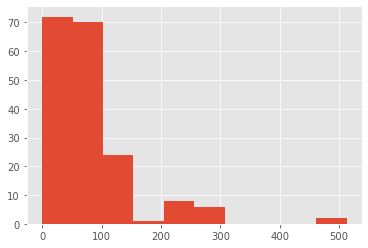

In [15]:
df['Fare'].hist()

In [16]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,1,38.0,1,0,71.2833,2
3,1,1,1,35.0,1,0,53.1000,0
6,0,1,0,54.0,0,0,51.8625,0
10,1,3,1,4.0,1,1,16.7000,0
11,1,1,1,58.0,0,0,26.5500,0


In [17]:
#Стандартизация данных
from sklearn import preprocessing

#Построение диаграмм рассеивания
from pandas.plotting import scatter_matrix

#Графика для интерпретации моделей
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

#Деревья решений для задачи классификации
from sklearn.tree import DecisionTreeClassifier

#Деревья решений для задач регрессии 
from sklearn.ensemble import RandomForestClassifier

#Калибровка деревьев решений
from sklearn.calibration import CalibratedClassifierCV

In [18]:
#Если в БД нет единой метрики, то стандартизируем данные
norm = preprocessing.StandardScaler()
norm.fit(df)
X = norm.transform(df)

In [19]:
from sklearn.model_selection import train_test_split

#Расщепление на обучающую и тестовую выборки

X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    # доля объёма тестового множества
                                                    test_size=0.2)

In [20]:
model = DecisionTreeClassifier(random_state=42,
                               # функция для impurity ('gini' или 'entropy')
                               criterion='gini',
                               # максимальная глубина дерева
                               max_depth=5,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=5,
                               # минимальное число элементов в листе (может быть долей)
                               min_samples_leaf=5,
                               # минимальное значение дельты impurity
                               # min_impurity_decrease=0,
                               # веса для классов (можно дополнительно штрафовать за ошибку в нужных классах).
                               # поддерживает опцию 'balanced'.
                               class_weight=None
                               
                              )

model.fit(X, y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

In [23]:
export_graphviz(model,
                out_file='tree.dot',
                #задать названия фич
                #feature_names=X.columns,
                class_names=None,
                #показывать названия полей у численных значений внутри узла
                label='all',
                #раскрашивать узлы в цвет преобладающего класса
                filled=True,
                #показывать значение impurity для каждого узла
                impurity=True,
                #показывать номера узлов
                node_ids=True,
                #Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                #Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=True,
                #Число точек после запятой для отображаемых дробей
                #precision=3
               )


In [29]:
#Графика для интерпретации моделей
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

import pydot
#Преобразуем файл .dot в .png
#node - номер узла, X[1]<=1.5 правило расщепления, gini, samples-доля наблюдений попавших в узел, p-value (p0, pX)
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image("tree.png")

#Модель позволяет оценить ценность (importance) и эффективность каждой фичи, считая для каждой из сумму дельты H 
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', 
            ascending=False
            )


,feature,importance
1,Sex,0.499773
2,Age,0.349978
5,Fare,0.137144
4,Parch,0.008335
0,Pclass,0.004769
3,SibSp,0.000000
6,Embarked,0.000000


In [30]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#Строим предсказание модели на тестовом множестве
y_pred = model.predict(X_test)

#Оценка качества классификатора: доля совпавших ответов в y_pred и y_test, или считаем точность и полноту
#Если доля в обучающем выше тестового, означает переобученность модели. Нужно упрощать модель
#Матрица ошибок  𝐶=(𝑐𝑖,𝑗) , где  𝑐𝑖,𝑗 количество элементов класса 𝑖 , которым классификатор присвоил класс 𝑗 
#Точность(precision) - доля правильно классифицированных объектов в найденных классификатором. 
#Полнота(recall) - доля этих объектов НА САМОМ ДЕЛЕ
conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,11,3
1,2,21


In [31]:
#Гармоническое среднее F1 = 2*точность*полнота/(точность+полнота). Считается с помощью classification_report
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.91      0.88      0.89        24

    accuracy                           0.86        37
   macro avg       0.85      0.86      0.85        37
weighted avg       0.87      0.86      0.87        37



In [22]:
#Статистика по всем
td.describe(include="all")

NameError: name 'td' is not defined

In [ ]:
#Только по цифровым колонкам ищем нужное нам значение
td.mean(numeric_only = True)

In [ ]:
#Тепловая карта пропущенных значений
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [ ]:
#Преобразуем колонку с объектами в числовую
level_map = {"male": 1, "female": 0}
td['Sex'] = td['Sex'].map(level_map)

#Преобразуем Dtype колонки в bool
td['Survived'] = td['Survived'].astype('bool')

In [ ]:
#Статистика по родственникам на борту
td[['Parch', 'SibSp']].value_counts()

In [ ]:
#Оцениваем возраст
td["Age"].unique()
td["Age"].mean()
td_age = td['Age'].value_counts()
age_24_30 = td_age.loc[[24.00, 30.00]]
td.loc[:10, ["Age", "Sex"]]

In [ ]:
#Зависимая и независимые переменные. Сортировка выживших по полу и возрасту. 
td[["Survived", "Age", "Sex"]].value_counts().loc[1]

In [ ]:
#Зависимая и независимые переменные. Средняя доля выживших и среднее по возрасту и цене билета
td[["Survived", "Age", "Fare"]].mean(axis=0)

In [ ]:
#Получение сокращенного фрейма по конкретным критериям
td[td["Sex"].isin([True])].head()

In [ ]:
#Сортировка
td.sort_values('Age', ascending=False).head()

In [ ]:
#Агрегирование. Подсчет количества записей
td.groupby('Fare').count()

In [ ]:
#Рисуем гистограмму
td['Age'].hist(bins=40)

In [ ]:
#новые категории тарифов в новый столбец Fare_Category.
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid', 'High_Mid','High'])

In [ ]:
td.groupby('Survived')['Age'].plot.hist(density=True)
plt.legend()

In [ ]:
for column in ['Survived', 'Pclass', 'Sex']:
    print(td[column].value_counts(normalize=True))

In [ ]:
# Нужно, чтобы подписи к картинкам отображались корректно по-русски
matplotlib.rc('font', family='Arial')

In [ ]:
# Строим картинку
td['Survived'].value_counts().plot(kind='bar')
# Добавляем подпись
plt.title(u'Число выживших на Титанике')
plt.xticks([0, 1], ['Not Survived', 'Survived'], rotation=None)
plt.text(-0.1, 275, '61.5%', fontsize=15, color='silver')
plt.text(0.9, 150, '38.5%', fontsize=15, color='silver');

In [ ]:
#Доля выживших на Титанике
fig, ax = plt.subplots(1)
td['Survived'].value_counts().plot(kind='pie', labels=['', ''],
                                   ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title(u'Доля выживших на Титанике')
ax.axis('equal')
ax.legend(labels=[u'Выжили', u'Погибли'], framealpha=0)
ax.set_ylabel('')
plt.tight_layout()

In [ ]:
td['Age'].plot(kind='box')
plt.title(u'Распределение возраста')

In [ ]:
ax = td.boxplot(column='Survived', by='Pclass')
# Хак для того, чтобы исправить наезжающие заголовки графика
ax.get_figure().suptitle('')

In [ ]:
#иерархический кластерный анализ
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
td_new = td[important]
td_new.head()